# Moélisation de courbes de taux

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.interpolate import CubicSpline

In [178]:
# Import data
df = pd.read_excel("Data.xlsx")
df.columns = ["Market", "MAT", "MKT"]

In [179]:
df.head()
#df["MKT"] = 100 * df["MKT"]

,Market,MAT,MKT
0,MM,0.25,0.030698
1,MM,0.50,0.026191
2,MM,0.75,0.023958
3,MM,1.00,0.022979
4,FUT,1.25,0.978691


In [210]:
yield_zc = pd.concat([df_MM, df_FUT, df_SWAP])

In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

def bootstrap_yield_curve(df):
    # Interpolation des taux SWAP pour obtenir des cotations annuelles
    SWAP = df[df["Market"]=="SWAP"]
    spline = CubicSpline(SWAP["MAT"], SWAP["MKT"])
    maturities_annual = np.arange(3, 31, 1)  # Maturités annuelles
    interpolated_rates = spline(maturities_annual)
    
    SWAP_interpolated = pd.DataFrame({"Market":"SWAP",
                                      "MAT":maturities_annual,
                                      "MKT":interpolated_rates})
    
    # Ajout des points interpolés au DataFrame initial
    df_new = pd.concat([df[df["Market"] != "SWAP"], SWAP_interpolated])
    
    # 1️⃣ Calcul des taux zéro-coupon pour le marché monétaire (MM)
    df_MM = df_new[df_new["Market"]=="MM"].reset_index(drop=True)
    df_MM["B(0,MAT)"] = 1 / (1 + df_MM["MAT"] * df_MM["MKT"])
    df_MM["tx ZC"] = -np.log(df_MM["B(0,MAT)"]) / df_MM["MAT"]
    
    # 2️⃣ Calcul des taux zéro-coupon pour les Futures (FUT)
    df_FUT = df_new[df_new["Market"]=="FUT"].reset_index(drop=True)
    df_FUT["B(0,MAT)"] = df_MM["B(0,MAT)"].iloc[-1]  # Initialisation

    B_tau_i = df_FUT.loc[0, "B(0,MAT)"]
    tau_i = 1
    for i in range(len(df_FUT)):
        T_i = df_FUT.loc[i, "MAT"]
        f_i = df_FUT.loc[i, "MKT"]
        df_FUT.loc[i, "B(0,MAT)"] = B_tau_i / (1 + (T_i - tau_i) * (1 - f_i))
        tau_i = T_i
        B_tau_i = df_FUT.loc[i, "B(0,MAT)"]
    
    df_FUT["tx ZC"] = -np.log(df_FUT["B(0,MAT)"]) / df_FUT["MAT"]

    # 3️⃣ Calcul des taux zéro-coupon pour les Swaps (SWAP)
    df_SWAP = df_new[df_new["Market"]=="SWAP"].reset_index(drop=True)
    df_SWAP["B(0,MAT)"] = df_FUT["B(0,MAT)"].iloc[-1]  # Initialisation

    B_T_1 = df_MM.loc[df_MM["MAT"] == 1, "B(0,MAT)"].values[0]
    B_T_2 = df_FUT.loc[df_FUT["MAT"] == 2, "B(0,MAT)"].values[0]
    A = 1 + B_T_1 + B_T_2

    for i in range(len(df_SWAP)):
        df_SWAP.loc[i, "B(0,MAT)"] = 1 - df_SWAP.loc[i, "MKT"] * A
        A += df_SWAP.loc[i, "B(0,MAT)"]
    
    df_SWAP["tx ZC"] = -np.log(df_SWAP["B(0,MAT)"]) / df_SWAP["MAT"]

    # 4️⃣ Concatenation des résultats et affichage de la courbe
    yield_curve = pd.concat([df_MM, df_FUT, df_SWAP])
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=yield_curve["MAT"], y=yield_curve["tx ZC"], marker="o", linestyle="-", label="Courbe des taux zéro-coupon")
    plt.xlabel("Maturité")
    plt.ylabel("Taux zéro-coupon")
    plt.title("Courbe des taux zéro-coupon interpolée")
    plt.legend()
    plt.show()
    
    return yield_curve


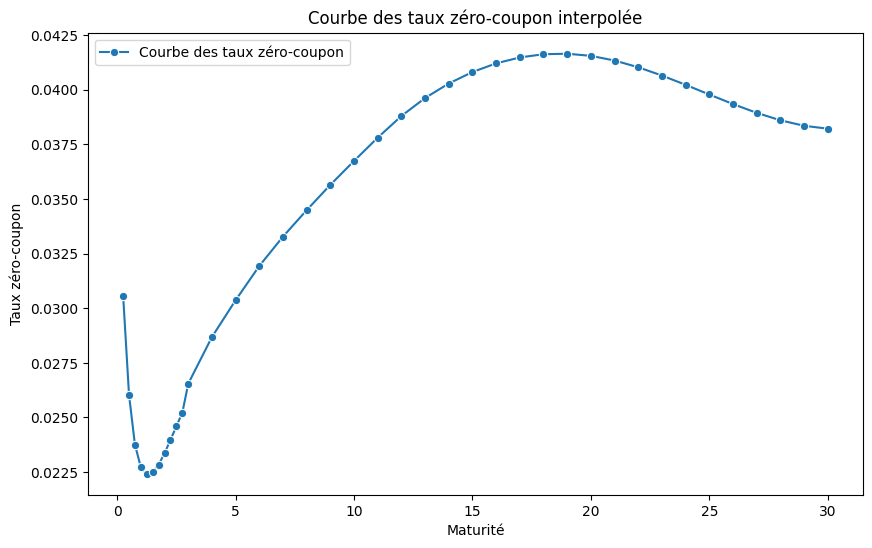

In [235]:
yield_zc = bootstrap_yield_curve(df)

In [247]:
#1.3
# Courbe des taux forward de tenor 3 mois

from scipy.interpolate import interp1d, CubicSpline

def compute_forward_rates(yield_curve):
    """
    Calcule les taux forward 3M à partir des taux zéro-coupon.
    
    Parameters:
    yield_curve (pd.DataFrame): Contient 'MAT' (maturité) et 'B(0,MAT)' (Prix ZC).
    
    Returns:
    pd.DataFrame: Contenant 'MAT' et 'Forward 3M'.
    """
    
    # Convertir les maturités en mois
    yield_curve["MAT_months"] = yield_curve["MAT"] * 12
    
    # Sélection des maturités tous les 3 mois
    maturities = np.arange(3, max(yield_curve["MAT_months"]), 3) / 12  # en années

    # Interpolation linéaire pour estimer B(0,T) pour ces maturités
    interp_bond_prices = interp1d(yield_curve["MAT"], yield_curve["B(0,MAT)"], kind="linear", fill_value="extrapolate")
    
    # Calcul des prix interpolés
    B_t = interp_bond_prices(maturities)  
    B_t_3M = interp_bond_prices(maturities + 0.25)  # 3 mois plus tard

    # Calcul du taux forward 3M
    forward_rates = ((B_t / B_t_3M) - 1)/0.25

    return pd.DataFrame({"MAT": maturities, "Forward 3M": forward_rates})

def plot_forward_curve(forward_rates):
    """
    Trace la courbe des taux forwards en utilisant l'interpolation linéaire et spline.
    
    Parameters:
    forward_rates (pd.DataFrame): Contenant 'MAT' et 'Forward 3M'.
    """
    
    # Interpolation linéaire et par spline
    linear_interp = interp1d(forward_rates["MAT"], forward_rates["Forward 3M"], kind="linear", fill_value="extrapolate")
    spline_interp = CubicSpline(forward_rates["MAT"], forward_rates["Forward 3M"])

    # Génération des points pour le tracé
    mat_range = np.linspace(min(forward_rates["MAT"]), max(forward_rates["MAT"]), 100)
    linear_values = linear_interp(mat_range)
    spline_values = spline_interp(mat_range)

    # Tracé des courbes
    plt.figure(figsize=(10, 6))
    plt.plot(mat_range, spline_values, linestyle="-", label="Interpolation Spline", color="red")
    plt.plot(mat_range, linear_values, linestyle="--", label="Interpolation Linéaire", color="blue")
    plt.scatter(forward_rates["MAT"], forward_rates["Forward 3M"], color="black", label="Points calculés", zorder=1)

    plt.xlabel("Maturité (années)")
    plt.ylabel("Taux Forward 3M")
    plt.title("Courbe des Taux Forwards 3M")
    plt.legend()
    plt.grid()
    plt.show()


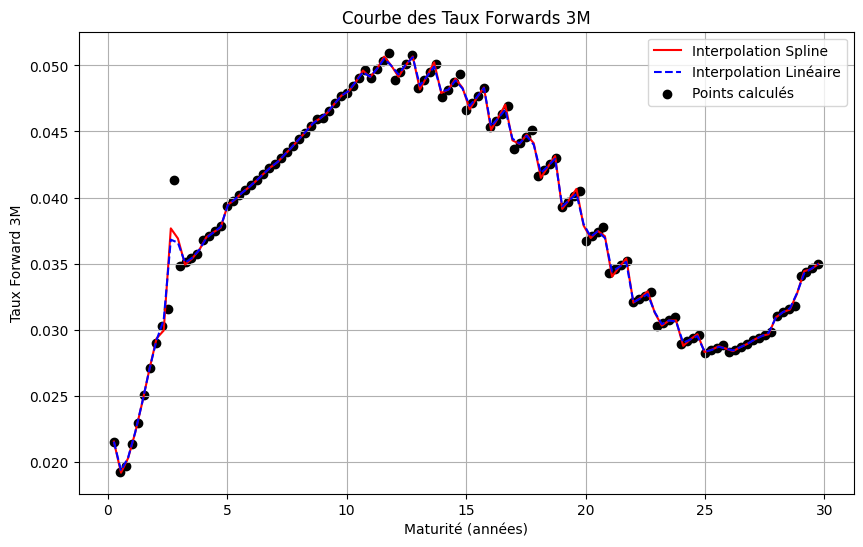

In [248]:
# Calcul de la courbe des taux forwards
forward_rates = compute_forward_rates(yield_zc)

# Tracé des courbes interpolées
plot_forward_curve(forward_rates)


In [240]:
df_bumped = df.copy()
df_bumped.loc[df_bumped["MAT"]==5,"MKT"] = df_bumped.loc[df_bumped["MAT"]==5,"MKT"] + 0.010

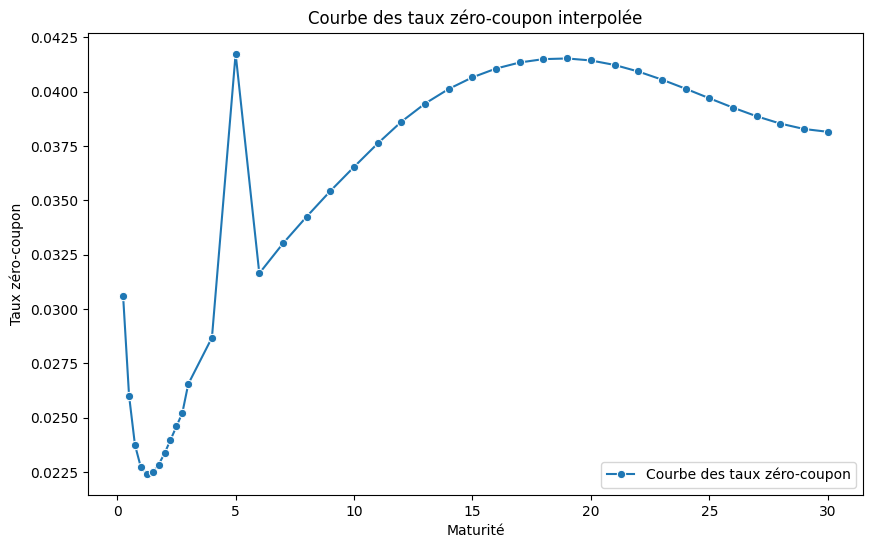

In [249]:
yield_bumped = bootstrap_yield_curve(df_bumped)

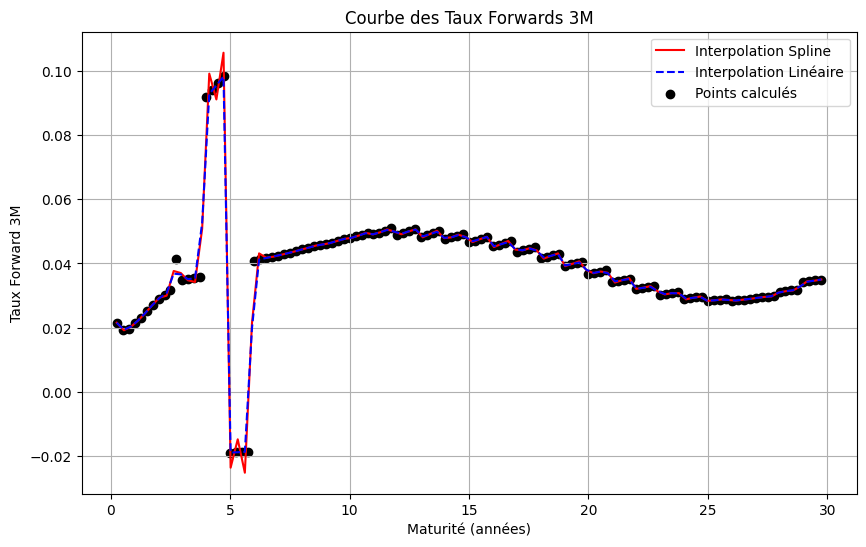

In [250]:
# Calcul de la courbe des taux forwards
forward_rates = compute_forward_rates(yield_bumped)

# Tracé des courbes interpolées
plot_forward_curve(forward_rates)
